In [1]:
# Imports needed in every section
import pandas as pd
import testing_scripts.constants as constants
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Section 1: Creating a labeled dataframe
This section involves reading in the resumes, filtering out entries whose CVs are too short, and creating positive and negative classes while filtering out all entries in neither class.

## From resumes parquet
This subsection assumes the existence of the resumes parquet file, processes, and exports the Labeled dataframe

In [5]:
# Read in the parquet
RESUMES_PARQUET_INPUT_FILENAME = "data/resumes.parquet"
raw_df = pd.read_parquet(RESUMES_PARQUET_INPUT_FILENAME, engine='pyarrow')  # raw dataframe

# Filter the dataframe by minimum cv length
MIN_CV_LENGTH = 1000
filtered_df = raw_df.loc[raw_df['CV'].dropna().apply(len) >= MIN_CV_LENGTH]

# Add a true label column based on the specified keywords
import testing_scripts.label_resumes
labeled_df = filtered_df.copy()
testing_scripts.label_resumes.add_true_label_column(labeled_df, constants.POSITIVE_POSITIONS, constants.POSITIVE_KEYWORDS, constants.NEGATIVE_POSITIONS, constants.NEGATIVE_KEYWORDS)

# Filter out entries whose true label is NA (i.e. belongs to neither class)
labeled_df = labeled_df[labeled_df["True Label"].notna()]

# # Export the labeled dataframe
# LABELED_DATAFRAME_OUTPUT_FILENAME = "data/labeled_df_PM vs UI_1000 chars min.csv"
# labeled_df.to_csv(LABELED_DATAFRAME_OUTPUT_FILENAME)

## From import
If the labeled_df.csv file already exists, run this instead to import the file

In [6]:
LABELED_DATAFRAME_INPUT_FILENAME = "data/labeled_df_PM vs UI_1000 chars min.csv"
labeled_df = pd.read_csv(LABELED_DATAFRAME_INPUT_FILENAME)

## True label playground
This subsection contains some light code for examining the true label

In [8]:
# The size of the positive and negative classes
value_counts = labeled_df["True Label"].value_counts()
print(value_counts)

positiveClassSize = value_counts.get(constants.POSITIVE_LABEL, default=0)
negativeClassSize = value_counts.get(constants.NEGATIVE_LABEL, default=0)
print(f"Proportion of positives = {positiveClassSize / (positiveClassSize + negativeClassSize)}")

True Label
1    5232
0    3596
Name: count, dtype: int64
Proportion of positives = 0.5926597190756683


In [75]:
cv_sample = labeled_df.loc[labeled_df["True Label"] == constants.NEGATIVE_LABEL].sample(n = 5, random_state = 0)
cv_sample["CV"].values[1]

In [313]:
# Example positive entry
example_positive_entry = labeled_df.loc[labeled_df["True Label"] == constants.POSITIVE_LABEL].iloc[0]
example_positive_cv: str = example_positive_entry.to_dict()["CV"]
print(f"Truncated positive CV:\n====================\n {example_positive_cv[:1000]}...")

Truncated positive CV:
 During my work in a role of a Client Success Manager, I was responsible for the large US-based accounts health and growth. I used to work on 3 - 4 large enterprise-level accounts in parallel with the total number of dedicated engineering teams 30 – 50 people.
I've generated a lot of ideas for improvements, participated in building up strong engineering teams and working out the processes and strategy for the clients, which have resulted in the account and team growth.
I had a chance to mentor and inspire many people, who have later become talented engineers and solution architects, and learn from them as well.
- Managing multiple accounts with different engagement models. 
- Managing all aspects of client relationships. 
- Analyzing client's business pain-points, assisting with the roadmap to help reaching out strategic goals. 
- Taking active part in the whole opportunity initiation process. Drafting Proposals and SOWs.
- Extending partnership with the existing

In [327]:
# Example negative entry 
example_negative_entry = labeled_df.loc[labeled_df["True Label"] == constants.NEGATIVE_LABEL].iloc[0]
example_negative_cv = example_negative_entry.to_dict()["CV"]
print(f"Truncated negative CV:\n====================\n {example_negative_cv[:1000]}")

Truncated negative CV:
 
•   Possession of Adobe Photoshop, Adobe-AI, skills of working with a graphic tablet;
•   UI/UX ;
•.  Figma, Zeplin, Sketch, MarvelApp, Invision;
•   2D graphics (understanding of pixel and vector graphics and their specifics);
•.  2D Design;
•.  3D Max;
•   Ability to work in different styles;
•   Ability to draw by hand;
•   Creation of design banners, layouts, logos, frameworks and prototypes for websites and mobile applications;
•   Testing of games;
•   Making presentations in Power Point;
Availability of portfolio;
Bug tracking systems and project management tools: Trello and Jira.
I'm self-motivated artist with a strong skills at game industry. I have more 5 years experience in game company, and now, I want to broaden my world with interesting projects, to share own experience and to acquire new skills and knowledge.
So, my goal is putting into practice somebody's dreams, in so doing, working with pleasure.
I would like to work at company with friendly t

# Section 2: Marking samples for Experiments
This section involves marking samples in the labeled dataframe for experiments. This allows us to experiment on a few samples at a time, rather than all entries at once.

## From labeled_df
This subsection assumes the existence of the labeled_df object within this notebook, processes, and exports the Marked dataframe

In [30]:
# How many samples from each class we want to mark for experiments
NUM_POSITIVE_SAMPLES = 100
NUM_NEGATIVE_SAMPLES = 100

# Create a new column "Marked for Experiments" and deterministically mark 
# the first NUM_POSITIVE_SAMPLES positive entries and the first NUM_NEGATIVE_SAMPLES negative entries True and all others false
marked_df = labeled_df.copy()
marked_df["Marked for Experiments"] = False
positive_sample_indices = marked_df[marked_df["True Label"] == constants.POSITIVE_LABEL].index[:NUM_POSITIVE_SAMPLES]
negative_sample_indices = marked_df[marked_df["True Label"] == constants.NEGATIVE_LABEL].index[:NUM_NEGATIVE_SAMPLES]
marked_df.loc[positive_sample_indices, "Marked for Experiments"] = True
marked_df.loc[negative_sample_indices, "Marked for Experiments"] = True

# Export the marked dataframe
MARKED_DATAFRAME_OUTPUT_FILENAME = "data/marked_df_100 PM vs 100 UI_1000 chars min.csv"
marked_df.to_csv(MARKED_DATAFRAME_OUTPUT_FILENAME)

## From import
If the marked_df.csv file already exists, run this instead to import the file

In [10]:
MARKED_DATAFRAME_INPUT_FILENAME = "data/marked_df_100 PM vs 100 UI_1000 chars min.csv"
marked_df = pd.read_csv(MARKED_DATAFRAME_INPUT_FILENAME)

## Mark playground
This subsection contains some light code for examining the true label

In [11]:
# The total number of marked entries (should match NUM_POSITIVE_SAMPLES + NUM_NEGATIVE_SAMPLES)
value_counts = marked_df["Marked for Experiments"].value_counts()
print(f"Number of samples = {value_counts.get(True)}")

Number of samples = 200


# Section 3: Generating tailored resumes
This section involves generating resumes tailored toward a specific job over the samples marked for experiments

## From marked_df
This subsection assumes the existence of the marked_df object within this notebook and generates modified resumes tailored toward the job specified in constants.py

In [20]:
import testing_scripts.generate_resumes as generate_resumes
generate_resumes.get_prompt_messages("{original_cv}", "Job description", "\{original_cv\}")

[{'role': 'user',
  'content': "I'm applying for a project manager job. Can you revise my resume for this project manager job? I will be disqualified if I lie about my qualifications, so it is imperative that the new resume accurately represents my actual responsibilities and experiences from my original resume. Also, please do not include any additional notes or explanation: I just want the text of the new resume. This is my resume: {original_cv}"}]

In [41]:
# Add tailored resumes based on the job description using the chosen model
# import testing_scripts.generate_resumes as generate_resumes
import testing_scripts.generate_resumes as generate_resumes

tailored_df = marked_df.copy()
# tailored_df = scored_df.copy()
generate_resumes.create_modified_resumes(tailored_df, job_name = constants.JOB_NAME, job_description = constants.JOB_DESCRIPTION, model_name = "GPT-4o Conversation", verbose = True)

# Export the tailored dataframe
TAILORED_DATAFRAME_OUTPUT_FILENAME = "data/tailored_df_100 PM vs 100 UI_1000 chars min_GPT-4o-mini Conversation_Anti-Hallucination Job Name Prompt.csv"
tailored_df.to_csv(TAILORED_DATAFRAME_OUTPUT_FILENAME)

Number of samples marked for experiments = 200
Generating a new tailored resume (2 generated so far)...
Generating a new tailored resume (3 generated so far)...
Generating a new tailored resume (4 generated so far)...
Generating a new tailored resume (5 generated so far)...
Generating a new tailored resume (6 generated so far)...
Generating a new tailored resume (7 generated so far)...
Generating a new tailored resume (8 generated so far)...
Generating a new tailored resume (9 generated so far)...
Generating a new tailored resume (10 generated so far)...
Generating a new tailored resume (11 generated so far)...
Generating a new tailored resume (12 generated so far)...
Generating a new tailored resume (13 generated so far)...
Generating a new tailored resume (14 generated so far)...
Generating a new tailored resume (15 generated so far)...
Generating a new tailored resume (16 generated so far)...
Generating a new tailored resume (17 generated so far)...
Generating a new tailored resume 

In [43]:
# Cleaning 
column_to_clean = tailored_df.columns[-1]
cleaned_df = generate_resumes.clean_column_resume(tailored_df, column_to_clean)

# Export the tailored dataframe
cleaned_DATAFRAME_OUTPUT_FILENAME = "data/cleaned_tailored_df_100 PM vs 100 UI_1000 chars min_GPT-4o-mini Conversation_Anti-Hallucination Job Name Prompt.csv"
cleaned_df.to_csv(cleaned_DATAFRAME_OUTPUT_FILENAME)

## From import
If the tailored_df.csv file already exists, run this instead to import the file

In [22]:
TAILORED_DATAFRAME_INPUT_FILENAME = "data/tailored_df_100 PM vs 100 UI_1000 chars min_GPT-4o-mini Conversation.csv"
tailored_df = pd.read_csv(TAILORED_DATAFRAME_INPUT_FILENAME)

## Tailored resumes playground
This subsection contains some light code for examining the tailored resumes

In [45]:
example_positive_entry = tailored_df[tailored_df["Marked for Experiments"] & tailored_df["True Label"] == constants.POSITIVE_LABEL].iloc[0]
example_positive_CV = example_positive_entry["CV"]
example_positive_tailored_CV = example_positive_entry["GPT-4o-mini Conversation-Improved Bits Orchestra PM CV"]

print(f"Truncated positive CV:\n====================\n {example_positive_CV[:750]}...")
print(f"\n\nTruncated positive tailored CV:\n====================\n {example_positive_tailored_CV[:750]}...")
# print(f"Example positive CV = {example_positive_cv}\n\n")

# example_tailored_positive_cv = generate_resumes.tailor_resume(example_positive_cv, job_description = constants.JOB_DESCRIPTION, model_name = constants.MODEL_NAME)
# print(f"Example positive tailored CV = {example_tailored_positive_cv}")

Truncated positive CV:
 During my work in a role of a Client Success Manager, I was responsible for the large US-based accounts health and growth. I used to work on 3 - 4 large enterprise-level accounts in parallel with the total number of dedicated engineering teams 30 – 50 people.
I've generated a lot of ideas for improvements, participated in building up strong engineering teams and working out the processes and strategy for the clients, which have resulted in the account and team growth.
I had a chance to mentor and inspire many people, who have later become talented engineers and solution architects, and learn from them as well.
- Managing multiple accounts with different engagement models. 
- Managing all aspects of client relationships. 
- Analyzing cli...


Truncated positive tailored CV:
 **[Your Name]**  
[Your Address]  
[City, State, Zip]  
[Your Email]  
[Your Phone Number]  
[LinkedIn Profile]  

---

**Professional Summary**  
Dedicated Client Success Manager with experi

In [344]:
example_negative_entry = tailored_df[tailored_df["Marked for Experiments"] & tailored_df["True Label"] == constants.NEGATIVE_LABEL].iloc[0]
example_negativeCV = example_negative_entry["CV"]
example_negative_tailored_CV = example_negative_entry[constants.tailored_CV_name(model_name = constants.MODEL_NAME, job_name = constants.JOB_NAME)]

print(f"Truncated negative CV:\n====================\n {example_negativeCV[:750]}...")
print(f"\n\nTruncated negative tailored CV:\n====================\n {example_negative_tailored_CV[:750]}...")
# print(f"Example positive CV = {example_positive_cv}\n\n")

# example_tailored_positive_cv = generate_resumes.tailor_resume(example_positive_cv, job_description = constants.JOB_DESCRIPTION, model_name = constants.MODEL_NAME)
# print(f"Example positive tailored CV = {example_tailored_positive_cv}")

Truncated negative CV:
 
•   Possession of Adobe Photoshop, Adobe-AI, skills of working with a graphic tablet;
•   UI/UX ;
•.  Figma, Zeplin, Sketch, MarvelApp, Invision;
•   2D graphics (understanding of pixel and vector graphics and their specifics);
•.  2D Design;
•.  3D Max;
•   Ability to work in different styles;
•   Ability to draw by hand;
•   Creation of design banners, layouts, logos, frameworks and prototypes for websites and mobile applications;
•   Testing of games;
•   Making presentations in Power Point;
Availability of portfolio;
Bug tracking systems and project management tools: Trello and Jira.
I'm self-motivated artist with a strong skills at game industry. I have more 5 years experience in game company, and now, I want to broaden my...


Truncated negative tailored CV:
 **[Your Name]**  
[Your Address]  
[City, State, Zip]  
[Your Email]  
[Your Phone Number]  
[LinkedIn Profile / Portfolio URL]  

---

**PROFESSIONAL SUMMARY**  
Self-motivated project manager and a

# Section 4: Scoring resumes
This section involves scoring the original and generated CVs

## From tailored_df
This subsection assumes the existence of the tailored_df object within this notebook and computes for both the original and generated CVs

In [47]:
# Add scores for both the original and generated CVs
import testing_scripts.score_resumes as score_resumes
# scored_df = tailored_df.copy()
# scored_df = marked_df.copy()
scored_df = cleaned_df.copy()

# score_resumes.append_scores(scored_df, job_description = constants.JOB_DESCRIPTION, CV_column_name = "CV", verbose = True)
score_resumes.append_scores(scored_df, job_description = constants.JOB_DESCRIPTION, CV_column_name = "Cleaned GPT-4o Conversation-Improved Bits Orchestra PM CV", verbose = True)

# Export the scored dataframe
SCORED_DATAFRAME_OUTPUT_FILENAME = "data/scored_df_100 PM vs 100 UI_1000 chars min_GPT-4o-mini Conversation Cleaned_Anti-Hallucination Job Name Prompt.csv"
scored_df.to_csv(SCORED_DATAFRAME_OUTPUT_FILENAME)

Number of samples marked for experiments = 200
Scoring a new resume (0 scored so far)...


100%|██████████| 252M/252M [00:06<00:00, 36.3MiB/s] 


Scoring a new resume (1 scored so far)...
Scoring a new resume (2 scored so far)...
Scoring a new resume (3 scored so far)...
Scoring a new resume (4 scored so far)...
Scoring a new resume (5 scored so far)...
Scoring a new resume (6 scored so far)...
Scoring a new resume (7 scored so far)...
Scoring a new resume (8 scored so far)...
Scoring a new resume (9 scored so far)...
Scoring a new resume (10 scored so far)...
Scoring a new resume (11 scored so far)...
Scoring a new resume (12 scored so far)...
Scoring a new resume (13 scored so far)...
Scoring a new resume (14 scored so far)...
Scoring a new resume (15 scored so far)...
Scoring a new resume (16 scored so far)...
Scoring a new resume (17 scored so far)...
Scoring a new resume (18 scored so far)...
Scoring a new resume (19 scored so far)...
Scoring a new resume (20 scored so far)...
Scoring a new resume (21 scored so far)...
Scoring a new resume (22 scored so far)...
Scoring a new resume (23 scored so far)...
Scoring a new resume

## From import
If the scored_df.csv file already exists, run this instead to import the file

In [4]:
SCORED_DATAFRAME_INPUT_FILENAME = "data/scored_df_100 PM vs 100 UI_1000 chars min_GPT-4o-mini Conversation Cleaned_Anti-Hallucination Job Name Prompt.csv"
# SCORED_DATAFRAME_INPUT_FILENAME = "data/test.csv"
scored_df = pd.read_csv(SCORED_DATAFRAME_INPUT_FILENAME)

## Scored resumes playground
This subsection contains some light code for examining the resume scores

In [51]:
# # Extract original CV score series
# # original_cv_scores: pd.Series = scored_df.loc[scored_df["CV Score"].notna(),"CV Score"]

# original_positive_cv_scores: pd.Series = scored_df.loc[scored_df["Marked for Experiments"] & (scored_df["True Label"] == constants.POSITIVE_LABEL), "CV Score"]
# original_negative_cv_scores: pd.Series = scored_df.loc[scored_df["Marked for Experiments"] & (scored_df["True Label"] == constants.NEGATIVE_LABEL), "CV Score"]

# ORIGINAL_POSITIVE_CV_SCORES_OUTPUT_FILENAME = "data/100 original PM CV scores_1000 chars min_GPT-4o-mini Conversation Cleaned_Anti-Hallucination Job Name Prompt.csv.csv"
# ORIGINAL_NEGATIVE_CV_SCORES_OUTPUT_FILENAME = "data/100 original UI CV scores_1000 chars min_GPT-4o-mini Conversation Cleaned_Anti-Hallucination Job Name Prompt.csv.csv"

# original_positive_cv_scores.to_csv(ORIGINAL_POSITIVE_CV_SCORES_OUTPUT_FILENAME)
# original_negative_cv_scores.to_csv(ORIGINAL_NEGATIVE_CV_SCORES_OUTPUT_FILENAME)

# Extract tailored CV score series
tailored_positive_cv_scores: pd.Series = scored_df.loc[scored_df["Marked for Experiments"] & (scored_df["True Label"] == constants.POSITIVE_LABEL), f"Cleaned GPT-4o Conversation-Improved Bits Orchestra PM CV Score"]
tailored_negative_cv_scores: pd.Series = scored_df.loc[scored_df["Marked for Experiments"] & (scored_df["True Label"] == constants.NEGATIVE_LABEL), f"Cleaned GPT-4o Conversation-Improved Bits Orchestra PM CV Score"]

TAILORED_POSITIVE_CV_SCORES_OUTPUT_FILENAME = "data/100 tailored PM CV scores_1000 chars min_GPT-4o-mini Conversation Cleaned_Anti-Hallucination Job Name Prompt.csv"
TAILORED_NEGATIVE_CV_SCORES_OUTPUT_FILENAME = "data/100 tailored UI CV scores_1000 chars min_GPT-4o-mini Conversation Cleaned_Anti-Hallucination Job Name Prompt.csv"

tailored_positive_cv_scores.to_csv(TAILORED_POSITIVE_CV_SCORES_OUTPUT_FILENAME)
tailored_negative_cv_scores.to_csv(TAILORED_NEGATIVE_CV_SCORES_OUTPUT_FILENAME)

In [52]:
# Import each type
# ORIGINAL_POSITIVE_SCORES_INPUT_FILENAME = ORIGINAL_POSITIVE_CV_SCORES_OUTPUT_FILENAME
# ORIGINAL_NEGATIVE_SCORES_INPUT_FILENAME = ORIGINAL_NEGATIVE_CV_SCORES_OUTPUT_FILENAME

# original_positive_cv_scores: np.ndarray = pd.read_csv(ORIGINAL_POSITIVE_SCORES_INPUT_FILENAME)["CV Score"].values
# original_negative_cv_scores: np.ndarray = pd.read_csv(ORIGINAL_NEGATIVE_SCORES_INPUT_FILENAME)["CV Score"].values

TAILORED_POSITIVE_SCORES_INPUT_FILENAME = TAILORED_POSITIVE_CV_SCORES_OUTPUT_FILENAME
TAILORED_NEGATIVE_SCORES_INPUT_FILENAME = TAILORED_NEGATIVE_CV_SCORES_OUTPUT_FILENAME

tailored_positive_cv_scores: np.ndarray = pd.read_csv(TAILORED_POSITIVE_SCORES_INPUT_FILENAME)["Cleaned GPT-4o Conversation-Improved Bits Orchestra PM CV Score"].values
tailored_negative_cv_scores: np.ndarray = pd.read_csv(TAILORED_NEGATIVE_SCORES_INPUT_FILENAME)["Cleaned GPT-4o Conversation-Improved Bits Orchestra PM CV Score"].values

In [53]:
# positive_cv_scores = original_positive_cv_scores
# negative_cv_scores = original_negative_cv_scores
# positive_name: str = "Original PM"          # change me
# negative_name: str = "Original UI"          # change me

positive_cv_scores = tailored_positive_cv_scores
negative_cv_scores = tailored_negative_cv_scores
positive_name: str = "Tailored PM"          # change me
negative_name: str = "Tailored UI"          # change me

'''
Collect key statistics
'''
num_positive_scores = positive_cv_scores.size
num_negative_scores = negative_cv_scores.size
positive_proportion = num_positive_scores / (num_positive_scores + num_negative_scores)
negative_proportion = 1 - positive_proportion

positive_mean = positive_cv_scores.mean()
positive_std = positive_cv_scores.std()
negative_mean = negative_cv_scores.mean()
negative_std = negative_cv_scores.std()

from sklearn.metrics import roc_curve, auc
y_true = np.concatenate((np.ones(num_positive_scores), np.zeros(num_negative_scores)))
y_score = np.concatenate((positive_cv_scores, negative_cv_scores))
FPRs, TPRs, thresholds = roc_curve(y_true, y_score, drop_intermediate=False) 
roc_auc = auc(FPRs, TPRs)

accuracies = positive_proportion * TPRs + negative_proportion * (1 - FPRs)
optimal_index = np.argmax(accuracies)
optimal_accuracy = accuracies[optimal_index]
optimal_threshold = thresholds[optimal_index]
optimal_TPR = TPRs[optimal_index]
optimal_TNR = 1 - FPRs[optimal_index]

conservatively_optimal_index = np.argmax(np.where(FPRs == 0, TPRs, -np.NAN))      # mask elements where FPR is not 0 with negative infinity
conservatively_optimal_TPR = TPRs[conservatively_optimal_index]
conservatively_optimal_threshold = thresholds[conservatively_optimal_index]


Tailored PM score mean = 87.475, std = 1.920
Tailored UI score mean = 84.542, std = 2.148
Optimal accuracy = 0.8
	Optimal threshold = 86.435
	Optimal TPR = 0.74
	Optimal TNR = 0.86
Conservatively optimal TPR = 0.06
	Conservatively optimal threshold = 89.956
AUC = 0.857


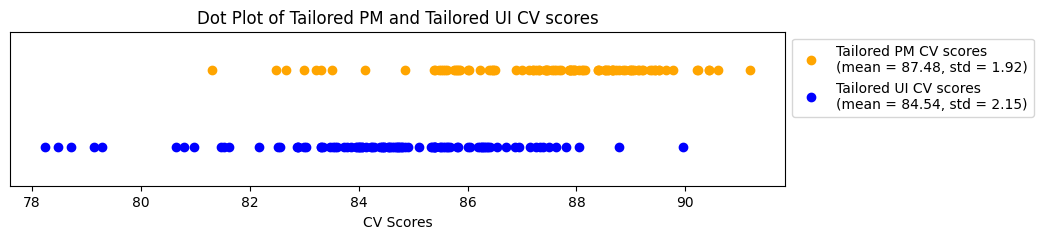

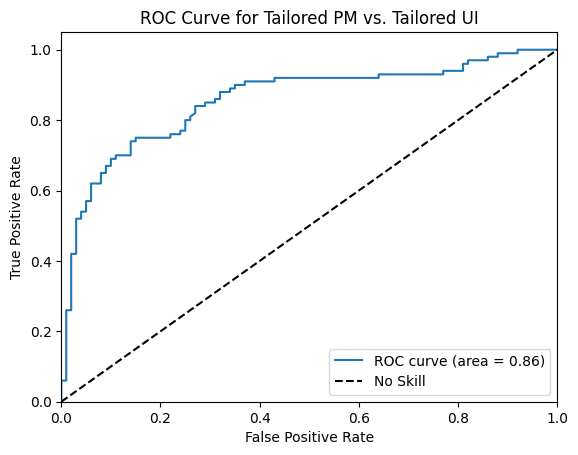

In [54]:
'''
Print report
'''
save_to_file: bool = False                   # change me


uppercase_first = lambda string : string[0].upper() + string[1:]    # capitalizes first letter
lowercase_first = lambda string : string[0].lower() + string[1:]    # uncapitalizes first letter

# Print statistics
print(f"{positive_name} score mean = {positive_mean:.3f}, std = {positive_std:.3f}")
print(f"{negative_name} score mean = {negative_mean:.3f}, std = {negative_std:.3f}")

print(f"Optimal accuracy = {optimal_accuracy}\n\tOptimal threshold = {optimal_threshold}\n\tOptimal TPR = {optimal_TPR}\n\tOptimal TNR = {optimal_TNR}")
print(f"Conservatively optimal TPR = {conservatively_optimal_TPR}\n\tConservatively optimal threshold = {conservatively_optimal_threshold}")
print(f"AUC = {roc_auc:.3f}")


# Plot the distributions as a dot plot
distribution_figure, distribution_ax = plt.subplots(figsize=(10, 2))  # Create a figure and axis

positive_distribution_plot_label: str = f"{uppercase_first(positive_name)} CV scores\n(mean = {positive_mean:.2f}, std = {positive_std:.2f})"
negative_distribution_plot_label: str = f"{uppercase_first(negative_name)} CV scores\n(mean = {negative_mean:.2f}, std = {negative_std:.2f})"
distribution_ax.plot(positive_cv_scores, np.ones_like(positive_cv_scores), 'o', color='orange', label = positive_distribution_plot_label)  # Plot the positive scores
distribution_ax.plot(negative_cv_scores, np.zeros_like(negative_cv_scores), 'o', color='blue', label = negative_distribution_plot_label)   # Plot the negative scores

distribution_ax.set_ylim([-0.5, 1.5])
distribution_ax.set_yticks([])                                                                                                                           # Set y-ticks to be hidden to make it look like a 1-dimensional plot
distribution_ax.set_xlabel('CV Scores')
distribution_ax.set_title(f'Dot Plot of {uppercase_first(positive_name)} and {uppercase_first(negative_name)} CV scores')
distribution_ax.legend(bbox_to_anchor=(1, 1), loc='upper left')                             # Move legend outside plot
# distribution_figure.show()        # causes strange error
plt.show()


# Plot the ROC curve
ROC_figure, ROC_ax = plt.subplots()

ROC_ax .plot(FPRs, TPRs, label='ROC curve (area = %0.2f)' % roc_auc)
ROC_ax .plot([0, 1], [0, 1], 'k--', label='No Skill')
ROC_ax.set_xlim([0.0, 1.0])
ROC_ax.set_ylim([0.0, 1.05])
ROC_ax.set_xlabel('False Positive Rate')
ROC_ax.set_ylabel('True Positive Rate')
ROC_ax.set_title(f'ROC Curve for {uppercase_first(positive_name)} vs. {uppercase_first(negative_name)}')
ROC_ax.legend()
plt.show()

# Export the plots
if save_to_file:
    distribution_plot_filename  = f"data/figures/{num_positive_scores} {lowercase_first(positive_name)} vs {num_negative_scores} {lowercase_first(negative_name)} CV scores_1000 chars min_GPT-4o-mini general.csv.png"
    ROC_plot_filename           = f"data/figures/{num_positive_scores} {lowercase_first(positive_name)} vs {num_negative_scores} {lowercase_first(negative_name)} CV ROC curve_1000 chars min_GPT-4o-mini general.csv.png"

    distribution_figure.savefig(distribution_plot_filename, bbox_inches='tight')    # prevent from cropping off
    ROC_figure.savefig(ROC_plot_filename, bbox_inches='tight')                      # prevent from cropping off

    print(f"Saved to {distribution_plot_filename}")
    print(f"Saved to {ROC_plot_filename}")

In [269]:
# Find the threshold that maximizes TPR subject to FPR <= 0.2
semiconservatively_optimal_index = np.argmax(np.where(FPRs <= 0.2, TPRs, -np.NAN))      # mask elements where FPR is not 0 with negative infinity
semiconservatively_optimal_TPR = TPRs[semiconservatively_optimal_index]
semiconservatively_optimal_threshold = thresholds[semiconservatively_optimal_index]

In [59]:
# Find rate of improvement
print(f"Number of positive CVs whose scores where improved = {np.count_nonzero(tailored_positive_cv_scores > original_positive_cv_scores)}/{num_positive_scores}")
print(f"Number of negative CVs whose scores where improved = {np.count_nonzero(tailored_negative_cv_scores > original_negative_cv_scores)}/{num_negative_scores}")

Number of positive CVs whose scores where improved = 98/100
Number of negative CVs whose scores where improved = 99/100


### Prompting Playground

In [65]:
example_positive_cv_list = [
    "- successful adoption and improvement of Scrum;\n- streamlined internal processes in R&D team (2018);\n- new tools implementation - Jira and Confluence for non-delivery teams (2017);\n- international accreditation for LvBS (2016).\nI have been Scrum Master in R&D team, which develops IoT platform. Apart from Scrum process adaptation and improvement, I worked on project management automation, building reporting system, budget tracking and other internal processes implementation as well as facilitation of cross-department cooperation. \n\nAs a result, we obtained renewed process flow for our development tasks, got new approach to tracking budget and scope, developed smoother on-boarding and off-boarding (project has high level of staff turnover).\n\nI discovered gap between Accounting reports and internal project budget tracking documents, so along with our CFO, I have worked on implementation of unified budget tracking report for Project Managers.\n\nOn my previous job, I lead the process of implementation of Jira and Confluence for non-delivery teams. This solved issue of tracking results of non-delivery teams.",
    "I am a highly accomplished Project Manager with a proven track record of consistently delivering outstanding results. In my current role at BDA, I have maintained an impressive 90% success rate in achieving project objectives, underscoring my exceptional project management capabilities. My tenure at Konsis Group involved overseeing high-profile projects for esteemed clients, successfully securing sponsorships, and delivering projects valued at 50k AZN, highlighting my proficiency in event coordination and adeptness in stakeholder engagement. My fluency in English, Azerbaijani, Turkish, and Russian enhances my communication skills for seamless international collaboration. Moreover, my international experience as an Activities Coordinator in the Netherlands, supported by The European Solidarity Corps, provided me with valuable insights into European workplace standards and bolstered my cross-cultural competence. I am unwavering in my dedication to continuous learning and professional growth.\nI am a dedicated and goal-driven professional with 5 years of experience in project and program support. My expertise lies in coordinating and managing diverse project activities, ensuring timely completion and goal achievement. I excel in team leadership, effective communication, problem-solving, and project management.  My roles as a Project Manager at Baku Design Academy, Freelance English Instructor, Activities Coordinator at Humanitas DMH, Project Manager at Konsis Group, Project Lead at Alliance NGO, and Teacher Assistant at High School № 286 have all contributed to my versatile skill set and commitment to achieving positive outcomes.\nI thrive in environments where project objectives are clear, resources and support are provided, and communication is open and transparent. Well-defined roles and responsibilities, access to modern project management tools, and regular updates on overarching goals are crucial for effective project management. Empowerment, recognition, and a healthy work-life balance are equally important to me. I value opportunities for professional development, effective conflict resolution, and the recognition of my expertise in the field. Fair compensation that reflects my experience and responsibilities is also a key expectation. Let's connect and work together to achieve project excellence!",
    "During my work as Head of the HR department, I built all the process inside the team from the beginning and implemented Scrum in our team management. Also, I have experience in building a big project in a previous company. The project is aimed to increase the awareness and the number of candidates for employment, as well as to improve the knowledge base of the company's employees. I managed this project from the beginning (recruit team, define the place, and organize all necessary facilities) till the end (run all events\\courses, calculate revenue).\nI have five years of experience in the HR sphere and one year in project coordination. My current position in Epam is an HR business partner, and I am simultaneously working as an HR coordinator in one of our big project. \n\nMy primary responsibilities for the HR coordinator position are:\n- Coordinating project management activities, resources, and information;\n- Assisting with project strategies;\n- Providing statistics on the performance of the team;\n- Reporting velocity and potential risks, and communicating the information with DM and PM of the project;\n- Ensuring project deadlines are met;\n- Analyzing potential risks and opportunities and providing solutions when applicable. \n\nAlso, I got an experience of working as a Head of HR department in a previous company. When I  was working as a Head of HR department, I managed the everyday work of the team: planning, setting up daily meetings, defining development vectors of the group, negotiations with CEO and external partners. I used Scrum for planning and control of work of our department (we practiced daily meeting, sprint planning, and retrospective)\n",
    "1000 successfully conducted projects from large-scale full CG videos to minute projects.\nTimely briefing and coordinating the internal resources involved in the projects.\nUsing internal tracking system to keep track of people and progress.\nMaking sure that all the aims of the project and quality standards are met.\nIntroduction of necessary changes in the course of the projects in rapidly changing conditions. Bidding process conduction, making cost estimations, handling cost-negotiations and contract arrangement.\nExperienced and devoted project manager with good communication skills and enthusiastic approach to challenges looking to start a career as a PM in software development company. Ready to learn fast and be persistent to become a master on the applied position.\nOver 8 years experience as a Senior project manager at one of the largest Ukrainian post-production studios (TV commercials and feature films).\nWould like to work as a PM in software development company with a young and outgoing team, deal with innovative projects, have an opportunity to develop my skills and knowledge in the new field.",
    "Search, develop & maintain relationships with business partners.\nMaintaining and participating in internal projects.\n-Bachelor's degree in \"Management of foreign economic activity\" and Master's degree in \"Management of organization\"\n- Finished course in A-Level \"IT Project Management:Extended\"\n- Basic skills of Project Management;\n- Understanding of Software development life cycle;\n- Basic knowledge of Atlassian: Jira; Confluence; Trello; Redmine;\n- Business negotiation with customers (European and Latin American countries) and conclusion of a contract;\n- Development cooperation with foreign countries (expansion of customer base, search for new customers)\n- Managing of internal projects (team of 4 managers);\n- Tasks delegation & managing;\n- Provision of annual / monthly reports;\n- Handling with project management documentation;\n- Analytical and negotiation skills;\n- MS Office (Word; Excel; Outlook; PowerPoint), 1C (basics);\n- Speed Touch Typing (Cyrillic & Latin).\nI'd like to start working as a PM in a team of professional, hard-working, result-oriented and friendly people. \nI'm  self-motivated, easygoing, initiative, responsible, stress resistant and fast learning and I have strong desire to grow and develop my skills."
]

example_negative_cv_list = [
    "\nEASTERN Airlines — UX/UI Designer\n\nCreated design from scratch for Eastern Airlines website and app together with marketing and development teams. I was responsible for the entire cycle of product design, starting from an analysis of previous digital products as well as our competitors services, finding out pains of our customers, forming a new vision of our product, сonducting surveys, making & testing prototypes, analyzing UX to avoid mistakes (typical for airlines services), creating user flow/mind maps/ personas, working on UI (UI kit: fonts, colors, visuals, made custom icons and illustrations specifically for the project images, different states, animations), working closely with dev team e.g. discussing development stages, possible changes, testing, and fixing mistakes. Working on an emotional design by making the website and app products people will love. \n\n\n\nLTU Media — UX/UI Designer\nWorked in Israeli company with a design team. Worked with different languages (Hebrew/Chinese/English) and different tools (Figma/Adobe XD/Adobe Photoshop",
    "I am a Junior UI/UX designer. I am engaged in full-cycle design: I analyze, create interface prototypes, create a visual style and translate all this into a convenient and simple final product.\n\nTools: Figma, Adobe Photoshop, Adobe Illustrator.\n\nSkills and the way to create a site:\n\n- Analysis of competitors;\n\n- Determination of the target audience;\n\n- Wireframing;\n\n- Prototyping;\n\n- Userflow;\n\n- Testing;\n\n- Creation of UI;\n\n- Convenient interface;\n\n- Basic HTML/CSS.\n\nPersonal qualities:\n\n- Communication;\n\n- Ability to work in a team;\n\n- I am not afraid of a large amount of work and difficult tasks;\n\n- Learning quickly;\n\n- I don't stand still, I'm always learning and developing.\nI developed websites for educational projects, for sales of psychologist services, a company engaged in repairs, and a company that sells pallets.\nDuring site development, competitor and target audience analysis was carried out, User flow and wireframe, prototyping and UI design, layout on Webflow were developed.",
    "I'm proud of my high level of self-organization and self-motivation. Over the last 5 years I have had up to 10 regular clients, for whom I satisfied everyday design needs, I have had many realized individual projects,  I have been trained and received a UI/UX certificate in Hillel IT School, have worked as a mentor on UI/UX online course, have successfully worked as remote UI/UX designer at Irish digital marketing company.\nI am experienced UI/UX and Graphic Designer with a 5+ years history of working in the visual design industry. Love to arrange space around me. So that love to arrange visual content to achieve business goals. Happy clients motivate me to move forward and bring even more benefit by my work. \n- I help clients to turn the idea into visualized prototype. \n- I offer solutions that meet users’ needs and help to achieve business goals. \n- I’m client-oriented and good at soft skills, which allows me to keep positive and productive relationships with the team and clients.\n\nNow I work through the UI/UX Design stages depending on the client requirements and also for the internal company needs. I provide UX Research, UX Review, Prototypes, Wireframes, Visual Concepts, UI kits, Design Components kits, ready for development Interface Solutions. \nAlso I create visual design materials for digital marketing purpose - banners, illustrations, social media content, corporate branded docs, presentations, e-books, ets.\n\nI realized UX/UI projects in  SaaS, ecommerce, furniture, finance, insurance, education and other fields. \n\nI have experience of independent remote work, as well as experience of working together in a remote and office team.\nI want to be a part of the team and improve my skills to bring maximum value to the company. So, it should be friendly, professional and ambitious people who want to make product better and don't forget about personal growth.",
    "________ agreements with 4 long-term clients (1 year+ LTV) ________ 2 new sales channels implemented ________ updated sales/marketing and web production processes ________ increased positions of design agency to top 40 on Clutch ________ managed 20+ projects _________ created PR campaing in collaboration with Verkhovna Rada _________\n____________ Head of full cycle design agency  ____________  Head of Marketing at full cycle design agency  ____________ Head of Marketing at USA based B2C startup  ____________ Co-Founder at video marketing agency ____________ PM at website studio ____________ Manager at educational startup _________________________________________\n\nAt my previous workplace, I've managed a design agency (15+ members), working with sales, marketing, design and development teams. I'm working with UX researches and products improvement backlog and roadmaps, company strategy, communication with clients and subcontractors, CRM, and GA data analytics.\nI'm looking for an IT company to create a product together. I'm in love with work together with creative people (designers and content makers). But I'm sure that the best creative approach is data-driven and structured decisions",
    "\nI've been working as a hybrid - UX/UI designer and mobile developer for about 3 years.\n\nCurrently, I'm focused on UX/UI Design. My favorite parts of the process are planning user flow and working on UI. My past coding experience helps me think from a developer's perspective when working on UX, so I create realistic designs and can easily communicate with the developers' team.\n\nIn a nutshell, my workflow for the projects looked as follows:\n- communication with a client in the early stages to collect all specifications and set goals for the project\n- collaborate with the product manager, and front and back-end developers using Atlassian’s project management tools.\n- worked with the team in 2-week sprints to ensure on-time and quality delivery.\n- create designs in Figma and present them to the client and team. (I usually go straight to the hi-fi, since I was working alone on designs, but I'm good at wireframing as well)\n- design iterations (depends on the time and budget)\n- implement the design in Flutter \n- work on app navigation\n- the client gives beta-version for testing\n- bug fixing and updates\n- support the project after release (if required)"
]

In [93]:
# Design prompts here
from typing import List, Dict
def get_prompt_messages(original_cv: str, job_description: str, job_name: str) -> List[Dict[str, str]]:
    message1A = f"I'm applying for a project manager role. This is the job description: {job_description}.\nPlease wait for further instructions"
    message1B = f"Got it! I'll wait for your next instructions. Just let me know how you'd like to proceed or if you need help with anything specific regarding your application."
    
    message2A = f"Can you revise my resume for this job?"
    message2A += f"I will be punished if I lie about my qualifications, so it is imperative that the new resume does not add any facts that are not in the original resume."
    message2A += f"Also, please do not include any additional notes or explanation: I just want the text of the new resume."
    message2A += f"Again, ensure that the output accurately represents my actual responsibilities, experiences, and skills."
    message2A += f"This is my resume: {original_cv}"

    messages = [
        {"role": "user", "content": message1A},
        {"role": "assistant", "content": message1B},
        {"role": "user", "content": message2A}
    ]

    return messages

# # Example
# response = constants.gpt4omini_conversation([   {"role": "user", "content": "Write a haiku about bugs"},
#                                                 {"role": "assistant", "content": "Creeping through the leaves,  \nWhispers of wings in the dusk,  \nNature's tiny beads."},
#                                                 {"role": "user", "content": "Now replace wings with burgers"}
# ])
# print(response)

In [32]:
def compare_for_hallucinations(original_cv: str, edited_cv: str) -> str:
    prompt = f"This is Resume 1: {original_cv}.\n\nThis is Resume 2: {edited_cv}\n\nI would like to know whether the second resume has any facts that are explicitly or implicitly not in the first resume"
    return constants.gpt4omini_callable(prompt)

In [94]:
example_original_cv: str= example_negative_cv_list[2]

example_edited_cv: str = constants.gpt4omini_conversation(get_prompt_messages(original_cv = example_original_cv, job_description = constants.BITS_ORCHESTRA_PM_JOB_DESCRIPTION, job_name = constants.BITS_ORCHESTRA_PM_JOB_NAME))

hallucination_comparison: str = compare_for_hallucinations(example_original_cv, example_edited_cv)

In [95]:
print(f"EXAMPLE ORIGINAL:\n========================================\n{example_original_cv}\n\nEXAMPLE EDITED:\n========================================\n{example_edited_cv}\n\nCOMPARISON:\n========================================\n{hallucination_comparison}")

EXAMPLE ORIGINAL:
I'm proud of my high level of self-organization and self-motivation. Over the last 5 years I have had up to 10 regular clients, for whom I satisfied everyday design needs, I have had many realized individual projects,  I have been trained and received a UI/UX certificate in Hillel IT School, have worked as a mentor on UI/UX online course, have successfully worked as remote UI/UX designer at Irish digital marketing company.
I am experienced UI/UX and Graphic Designer with a 5+ years history of working in the visual design industry. Love to arrange space around me. So that love to arrange visual content to achieve business goals. Happy clients motivate me to move forward and bring even more benefit by my work. 
- I help clients to turn the idea into visualized prototype. 
- I offer solutions that meet users’ needs and help to achieve business goals. 
- I’m client-oriented and good at soft skills, which allows me to keep positive and productive relationships with the tea

Slope: 0.4666151128878661
Intercept: 49.360202282075264
Coefficient of determination: 0.3905224134635089


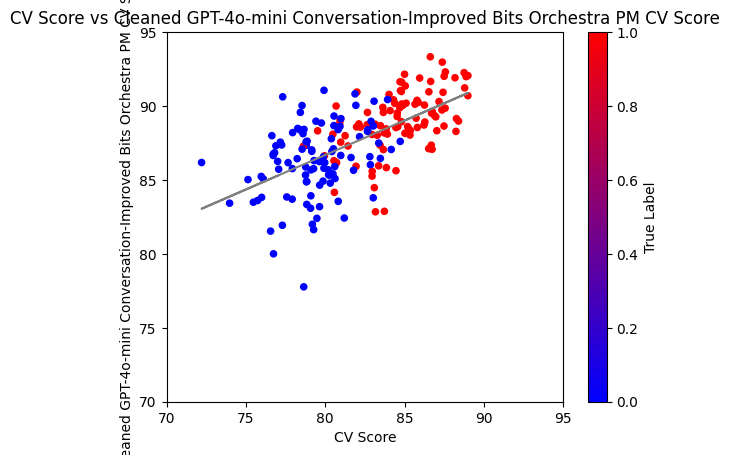

In [64]:
original_score_column_name = "CV Score"
modified_score_column_name = "Cleaned GPT-4o-mini Conversation-Improved Bits Orchestra PM CV Score"

all_scatterpoints: pd.DataFrame = scored_df.loc[scored_df["Marked for Experiments"], [original_score_column_name, modified_score_column_name, "True Label"]]
# Portray positive label as black and negative label as gray
from matplotlib.colors import LinearSegmentedColormap
POSITIVE_SCATTERPOINT_COLOR = "red"
NEGATIVE_SCATTERPOINT_COLOR = "blue"
positive_negative_colormap = LinearSegmentedColormap.from_list("Positive-Negative", [(constants.NEGATIVE_LABEL, NEGATIVE_SCATTERPOINT_COLOR), (constants.POSITIVE_LABEL, POSITIVE_SCATTERPOINT_COLOR)])
# Take nice square graph boundaries
x_min = all_scatterpoints[original_score_column_name].min()
x_max = all_scatterpoints[original_score_column_name].max()
y_min = all_scatterpoints[modified_score_column_name].min()
y_max = all_scatterpoints[modified_score_column_name].max()
import math
INCREMENT = 5
lower_boundary = math.floor( (min(x_min, y_min) - 0.1) / INCREMENT) * INCREMENT
upper_boundary = math.ceil( (max(x_max, y_max) + 0.1) / INCREMENT) * INCREMENT



score_scatterplot_axes = all_scatterpoints.plot.scatter(x = original_score_column_name, y = modified_score_column_name,
                                                    c = "True Label", colormap = positive_negative_colormap,
                                                    title = "CV Score vs Cleaned GPT-4o-mini Conversation-Improved Bits Orchestra PM CV Score",
                                                    xlim = (lower_boundary, upper_boundary), ylim = (lower_boundary, upper_boundary)
                                                    )

# Run linear regression on the combined 200 points
from sklearn.linear_model import LinearRegression
X = all_scatterpoints[[original_score_column_name]].values      # Reshaped into 2D array
y = all_scatterpoints[modified_score_column_name].values        # 1D array
linear_regression_model = LinearRegression()
linear_regression_model.fit(X, y)
# Get the coefficients
linear_regression_slope = linear_regression_model.coef_[0]
linear_regression_intercept = linear_regression_model.intercept_
linear_regression_coefficient_of_determination = linear_regression_model.score(X, y)
print(f"Slope: {linear_regression_slope}")
print(f"Intercept: {linear_regression_intercept}")
print(f"Coefficient of determination: {linear_regression_coefficient_of_determination}")
# Plot the combined plot
import matplotlib.pyplot as plt
predictions = linear_regression_model.predict(X)
score_scatterplot_axes.plot(X, predictions, color='gray', label='Regression Line')
plt.show()

In [65]:
# Import GPT-4o edited resumes
gpt4o_df = pd.read_csv("data/cleaned_chatgpt_generated_df_100 PM vs 100 UI_1000 chars min.csv")

In [73]:
# Take 10 random positive entries 
positive_examples = gpt4o_df.loc[(gpt4o_df["True Label"] == constants.POSITIVE_LABEL) & gpt4o_df["Marked for Experiments"]].sample(n = 10, random_state = 0)
negative_examples = gpt4o_df.loc[(gpt4o_df["True Label"] == constants.NEGATIVE_LABEL) & gpt4o_df["Marked for Experiments"]].sample(n = 10, random_state = 0)

In [152]:
for id in negative_examples["id"].values.tolist():
    print(id)

8a36386d-171a-543e-aea9-7e550b9a143e
da207c2d-2654-5bcf-a53d-25d0754d448b
bb923ed5-24e7-512e-a6d5-926715be4c30
7f5de827-e896-5e82-8eb7-95915719dce4
61a2d899-1a6a-5be0-929a-1c81bc25a682
a4eb539f-67d1-50e2-adc0-85a7595c2208
83f0c172-2f5c-5702-a663-adff7a45034f
8f653d9b-d9c7-5160-bbdb-15884b158b4b
13e9556c-b1ca-5f8d-a72e-f546e0d0c180
b2a613e2-6aef-5583-89aa-0c4cc4f3452b


In [40]:
import testing_scripts.generate_resumes as generate_resumes
index = 3
example_original_cv = tailored_df.loc[tailored_df["Marked for Experiments"] & (tailored_df["True Label"] == constants.NEGATIVE_LABEL)].iloc[index]["CV"]
example_edited_cv = generate_resumes.tailor_resume(example_original_cv, job_name = constants.JOB_NAME, job_description = constants.JOB_DESCRIPTION, model_name = "GPT-4o Conversation", verbose = True)
hallucination_comparison: str = compare_for_hallucinations(example_original_cv, example_edited_cv)

print(f"EXAMPLE ORIGINAL:\n========================================\n{example_original_cv}\n\nEXAMPLE EDITED:\n========================================\n{example_edited_cv}\n\nCOMPARISON:\n========================================\n{hallucination_comparison}")

Generating a new tailored resume (1 generated so far)...
EXAMPLE ORIGINAL:
• More than 12 years of experience in design.
• In total, more than 300 projects have been created, including:
• More than 30 products from scratch.
• More than 30 mobile applications.
• More than 80 websites.
• More than 100 logos and corporate styles.
• Creating and managing my own studio (20 people).
• Taught more than 150 students in UI/UX & brand design.
• Speaking at a Dribble & etc. conferences.
• Master's degree in “Engineering Design”.
• Studying for MBA Now.
Hi,

Design is my life.
I enjoy every pixel I create, every user delight and ah-ah moments. My dream is that design is taught in schools. If you need someone who will take your project apart, find the weak points, and improve it to perfection – that's me.

I had my own studio with 20 employees, with built processes for sales, management, hiring, and project creation. But I closed it in order to do what I loved: creating designs on my own.

I try no

In [175]:
print(negative_examples.iloc[9]["Cleaned gt4o-Improved Bits Orchestra PM CV"])

ResumeProfessional Summary:Passionate Project Manager with over a year of experience in managing and delivering projects in a fast-paced production environment. Proven ability to communicate effectively, manage multiple projects, and identify and mitigate project risks. Adept at using Agile methodologies and project management tools like Jira. Strong organizational skills and a creative mindset with the ability to think outside-of-the-box. Upper-intermediate level of English proficiency.Experience:Project ManagerTattoo Company Redesign Project- Managed the full project life cycle, including requirements gathering, creation of project plans and schedules, obtaining and managing resources, and facilitating project execution, deployment, and closure.- Redesigned the company's website to meet the needs of the target audience and modern trends, resulting in a more user-friendly interface that improved conversion rates and customer acquisition.- In cooperation with Technical Leads, created a